The modelling notebook will be divided into the following sections:
    
- Vectorization

Given that nature of our goal which is to classify in a binary fashion negative tweets from positive or neutral ones, tf-idf seems to be the best vectorization technique for our purposes. The tf-idf (**only fitted**) object is pickled so that it can be used in our analysis of fresh tweets later on. In this tf-idf object, the threshold of max and min doc frequency has been set at respectively 90 and 20 percent.

However, simple bag-of-words count vectorization will also be applied to our Naive Bayes model just to see if there is a siginificant difference in performance with different vectorization technique across the same model. Also, our deep learning model also requires a slightly different pre-processing method which it will be applied right before the CNN modelling.

- Splitting of the initial dataset into Training/Validation/Set

In this section, the tf-idf vector matrix along with our target is split into training, validation and test sets. Again, specifically for the Convolutional Neural Network, I'll need to perform an ad-hoc split for training and validation.


- Modelling

Modelling was carried out across several algorithms including Logistic Regression, Naive Bayes, Convolutional Neural Network and Decision Tree. Hyperparameter tuning with GridSearch CV has been applied to all models for some optimisations apart from CNN. The training data set was also tested with stratified k-fold objects with 10 and 5 n-splits.

Although f1 and accuracy were the main metrics we used to assess success, each model iteration also has a roc_plot. For all models apart from Logistic Regression, the curve drawn by the function is not a smooth curve. That's simply because the predict_proba function doesn't actualy return probabilities for Decision Trees and Naive Bayes models but only binary predicitons.

The best final performing model was a Logistic Regression with value C = 10 **with a final f1-score on the validation set of 98%**. 


- Evaluation of winning model on the test set

**The final winning model had also a 98% f1-score on the test set**. In this last section, I built a very quick confusion matrix to plot all the outcome results for the predictions. Type I and type II errors combined were only the 1.2% of our total test set composed by 8399 tweets. The best Logistic regression has also been pickled so that it can be used to make inferences on newly fresh tweets collected. The process of analysing fresh tweets and make predictions with the pickled model is explained in the other notebooks.

In [1]:
import keras
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime  
import numpy as np
import re
import seaborn as sns

import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# all models 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# evaluating performance
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score


from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

# functions for the convolutional neural network
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Conv1D, Flatten, LSTM , GRU, GlobalMaxPooling1D
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from joblib import dump, load
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

# importing custom functions
from functions.custom_function_5 import tokenize_tweet
from functions.custom_function_5 import get_tokens_frequency_df
from functions.custom_function_5 import plot_roc_curve_1
from functions.custom_function_5 import calculate_performance_1
from functions.custom_function_5 import max_seq_length

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/processed/data_for_modelling.csv')

# TF-IDF Vectorization

In order for models to understand raw text, one step that's necessary right before feeding the information to the algorithm is to vectorise all the text in our corpus. There are different ways to do this, the main two ones being the bag-of-words technique and the **tf-idf** method. The latter takes into account the 'rarity' of our words within the vocabulary and not only the frequency of occurence. In this specific context, tf-idf is a much better fit.

In the cell below, the max and minimum frequency of the document is set at respectively 0.9 and 2, taking into account only the most relevant 9000 words of our corpus. As explored in the EDA, we are taking into account n-grams up to three.

In [3]:
# instantiate the tf-idf object
tfidf_vectors = TfidfVectorizer(max_df=0.90, min_df=2, max_features=9000, 
                                stop_words='english',
                                ngram_range=(1, 3))



In this step, the matrix is not transformed yet since we need this object to make predictions on unseen text further down the pipeline of the project.
By pickling only the fit object we can iteratively transform each time new text on the base fit matrix. Unseen words will just be dropped whenever they are not in the original fit matrix below. 

In [4]:
tfidf_only_fit = tfidf_vectors.fit(df['tweet_without_stopwords_and_2'])

In [5]:
# pickling only the fit
pickle_out_only_fit = open('tfidf_pickle_fit', 'wb')
pickle.dump(tfidf_only_fit, pickle_out_only_fit)

In [6]:
# fitting and tranforming the matrix for the modelling here
tfidf = tfidf_vectors.fit_transform(df['tweet_without_stopwords_and_2'])

In [7]:
df_vector = pd.DataFrame(tfidf.todense(),columns = tfidf_vectors.get_feature_names())

# Splitting into Training/Validation/Test

This section just splits the initial dataset into three different subgroups, namely training, validation and test.
A stratified 10-fold obejct on teh training dataset will also later be created for further investigation and optimisation.

In [8]:
target = df['neg_label']


In [9]:
x_train, x_test, y_train , y_test = train_test_split(df_vector, target, 
                                                     test_size =.2, random_state=101 )

In [10]:
print(f'The shape of my training set is {x_train.shape}')
print(f'The shape of my training target is {y_train.shape}')
print(f'The shape of my test set is {x_test.shape}')
print(f'The shape of my test target is {y_test.shape}')

The shape of my training set is (33593, 9000)
The shape of my training target is (33593,)
The shape of my test set is (8399, 9000)
The shape of my test target is (8399,)


In [11]:
X_train, x_val, Y_train , y_val = train_test_split(x_train,y_train, 
                                                     test_size =.2, random_state=101 )

In [12]:
print(f'The shape of my final training set is {X_train.shape}')
print(f'The shape of my final training target is {Y_train.shape}')
print(f'The shape of my validation set is {x_val.shape}')
print(f'The shape of my validation target is {y_val.shape}')

The shape of my final training set is (26874, 9000)
The shape of my final training target is (26874,)
The shape of my validation set is (6719, 9000)
The shape of my validation target is (6719,)


# Logistic Regression Baseline

In [13]:
logmod = LogisticRegression(random_state=1002)

In [14]:
logmod.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1002, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
Logistic_Reg_Training = calculate_performance_1(logmod, X_train, Y_train, 'Logistic Regression Training')
Logistic_Reg_Training

,model,f1,accuracy,roc_score,precision
0,Logistic Regression Training,0.983148,0.98359,0.997736,0.992057


In [16]:
Logistic_Reg_Validation = calculate_performance_1(logmod, x_val, y_val, 'Logistic Regression Validation')
Logistic_Reg_Validation

,model,f1,accuracy,roc_score,precision
0,Logistic Regression Validation,0.973551,0.974252,0.995979,0.986981


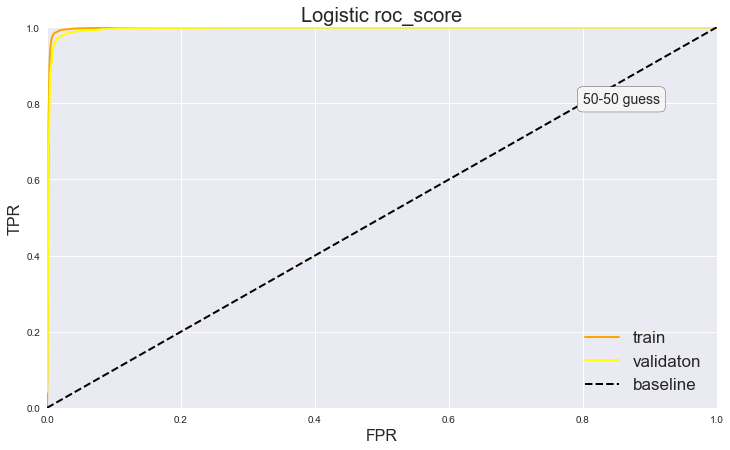

In [17]:
plot_roc_curve_1(logmod, X_train, x_val, Y_train, y_val, "Logistic" )

## Hyperparameter Optimisation of Logistic Regression with Gridsearch CV

In [18]:
skf = StratifiedKFold(n_splits=10, shuffle= True, random_state=102)

In [19]:
param_grid = {'C': [0.01,0.1,1,10,100]}

In [20]:
opt_model = GridSearchCV(LogisticRegression(class_weight = 'balanced', 
                                            random_state = 15 
                                            ),
                         param_grid,
                         cv=skf,
                         return_train_score=True,
                         scoring= 'accuracy')

In [21]:
opt_model.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=102, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=15, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [22]:
pd.DataFrame(opt_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.824892,0.442232,0.042256,0.006138,0.01,{'C': 0.01},0.923392,0.938267,0.933011,0.927428,...,0.928061,0.929508,0.929384,0.928805,0.930293,0.929921,0.928309,0.928970,0.929110,0.000706
1,1.704784,0.059337,0.039672,0.004741,0.1,{'C': 0.1},0.954258,0.963927,0.962039,0.953852,...,0.958904,0.960020,0.959648,0.958945,0.960144,0.959689,0.959069,0.959110,0.959457,0.000490
2,1.671123,0.034237,0.035150,0.003788,1,{'C': 1},0.971737,0.980662,0.980648,0.975065,...,0.983380,0.983876,0.983504,0.983007,0.983586,0.984082,0.983504,0.983173,0.983512,0.000366
3,1.686591,0.018502,0.035877,0.005090,10,{'C': 10},0.981778,0.988472,0.984369,0.981764,...,0.995576,0.995990,0.995700,0.995700,0.995866,0.995535,0.995700,0.995783,0.995754,0.000132
4,1.714762,0.014975,0.033518,0.002845,100,{'C': 100},0.978431,0.986984,0.982136,0.980648,...,0.998801,0.998966,0.998636,0.999008,0.999008,0.998801,0.998884,0.998760,0.998846,0.000119


In [23]:
print('Values of the optimised hyperparameters\nfor the best model found:\n',opt_model.best_params_)
opt_model.best_score_

Values of the optimised hyperparameters
for the best model found:
 {'C': 10}


0.9838505618813723

In [24]:
Logistic_Reg_Training_Opt = calculate_performance_1(opt_model, X_train, Y_train, 'Logistic Regression Training Optimised')
Logistic_Reg_Training_Opt


,model,f1,accuracy,roc_score,precision
0,Logistic Regression Training Optimised,0.995415,0.995498,0.999164,0.99583


In [25]:
Logistic_Reg_Validation_Opt = calculate_performance_1(opt_model, x_val, y_val, 'Logistic Regression Validation Optimised')
Logistic_Reg_Validation_Opt 

,model,f1,accuracy,roc_score,precision
0,Logistic Regression Validation Optimised,0.982696,0.983033,0.996584,0.989001


In [26]:
y_hat_log = opt_model.predict(x_val)

In [27]:
# visualising a quick confusion matrix for the validation set
confusion_matrix(y_val, y_hat_log)

array([[3368,   36],
       [  78, 3237]])

In [28]:
tn, fp, fn, tp = confusion_matrix(y_val, y_hat_log).ravel()
tn, fp, fn, tp

(3368, 36, 78, 3237)

Overall accuracy on the validation set for logistic regression with c = 10 is equal to **98.3%**, slightly better than the previous baseline one.

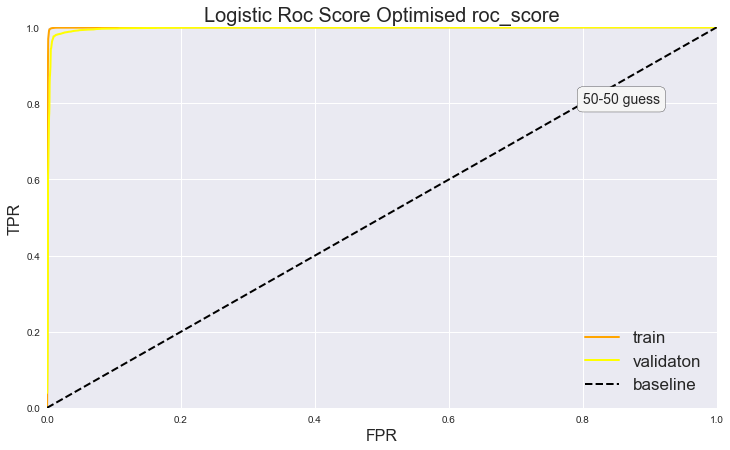

In [29]:
plot_roc_curve_1(opt_model, X_train, x_val, Y_train, y_val, "Logistic Roc Score Optimised" )

# Pickling the final winning model (previous version)

In [30]:
# logmodel

In [31]:
# pickle_out = open('pickled_logistic', 'wb')
# pickle.dump(logmodel, pickle_out)

# Convolutional Neural Network for Text Analysis

Let's try to analyse out Tweets with a fundamentally different method, namely Convolutional Neural Networks. Usually Recursive Neural Networks are the go-to for NLP problems but in this instance, a simple CNN will be applied in order to see whether there's a massive difference in terms of performance between the Logistic Regression approach and this one.

Neural Networks  analyse texts in a slightly different way with more dense vectors representing words as opposed to the potentially very sparse tf-idf framework. Given that our dataset is quite large, it might give a good idea to test a CNN and see if it manages to pick up patterns in a better way.

Another thing that needs to be said is also that the preprocessing slightly differ from the previous vectorization technique. Word embeddings are processed by Keras with the layer "Embedding.()" when it comes to the modelling.

In [32]:
df.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#12...,0,these hoes got more bodies than a cemetery ...,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
3,a friend just told me she's afraid to go to dc...,1,a friend just told me she's afraid to go to dc...,124,95,a friend just tell me she 's afraid to go to d...,a friend just tell me she 's afraid to go to d...,a friend just tell me she's afraid to go to dc...,friend tell 's afraid go dc rally amp attack #...,friend tell afraid rally amp attack berniebros...,0
4,i've noticed a lot of #icontf16 presentations ...,1,i've noticed a lot of #icontf presentations ...,117,95,i 've notice a lot of # icontf presentation me...,i 've notice a lot of #icontf presentation men...,i've notice a lot of # icontf presentation men...,'ve notice lot # icontf presentation mention h...,'ve notice lot icontf presentation mention hap...,0
5,getting for this weekends shows! #country #m...,0,getting for this weekends shows #country #m...,62,52,get for this weekend show # country # music # ...,get for this weekend show #country #music #lyl...,get for this weekend show # country # music # ...,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,0
6,@user my final legislative session day has of...,3,my final legislative session day has officia...,69,53,my final legislative session day have official...,my final legislative session day have official...,my final legislative session day have official...,final legislative session day officially begin...,final legislative session day officially begin...,0
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1
8,a #bikini kind of life ð´ summer #palmtrees ...,0,a #bikini kind of life summer #palmtrees ...,96,72,a # bikini kind of life summer # palmtrees # b...,a #bikini kind of life summer #palmtrees #bree...,a # bikini kind of life summer # palmtrees # b...,# bikini kind life summer # palmtrees # breeze...,bikini kind life summer palmtrees breeze place...,0
9,"very sad people with very sad lives, gossiping...",0,very sad people with very sad lives gossiping...,104,83,very sad people with very sad life gossip abou...,very sad people with very sad life gossip abou...,very sad people with very sad life gossip abou...,sad people sad life gossip people fuck # getalife,sad people sad life gossip people fuck getalife,0


In [33]:
# df['tokenized'] = df['tweet_without_stopwords_and_2'].apply(tokenize_tweet)

In [34]:
# df['tokenized'].head(5)

In [35]:

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df['tweet_without_stopwords_and_2'], df['neg_label'], test_size=0.2, random_state=78)



With the tokenizer object it is possible to decide the max number for our vocabulary along with some text processing such as filtering and lowering.
The fit_on_text method creates the word index based on its frequency. 

Each word is given an unique integer apart from 0 which is reserved for padding.
Lastly, text_to_sequences literally takes every single word and coverts it to its index value, thus creating a numerical sequence to represent each tweet.

In [36]:
# tk = Tokenizer(num_words=5000, # The 20000 most important words for our vocabulary
#                filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
#                lower=True, # Lowercase the text data for consistency
#                split=" ")
# tk.fit_on_texts(X_train_1) # Fit on our training set
# X_train_seq = tk.texts_to_sequences(X_train_1) # Indexed sequences based on fitted tokenizer
# X_test_seq = tk.texts_to_sequences(X_test_1)

In [37]:
tok = Tokenizer(num_words=5000,
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',
               lower=True,
               split=' ',
               oov_token=True)

tok.fit_on_texts(X_train_1)
X_train_seq = tok.texts_to_sequences(X_train_1)
X_test_seq = tok.texts_to_sequences(X_test_1)

Below there's an example of how a sequence looks like:

In [38]:
X_train_seq[19]

[56, 1845, 5, 14, 217, 51, 142, 4, 2034, 142, 4, 2148, 142, 61, 208, 1, 1099]

Created a custom function to find out what is the max length across all the sequences in teh training test. However, as exceptions, there might be longer ones either in the validation or test set so I'll set the max length to 10 more than 23 just in case.

In [39]:
max_seq_length(X_train_seq)

23

In [40]:
max_length = 23

Below is the number of total words in the corpus. 
That is also because I set the number of max_words in the tokenizer at 20000.
     

In [41]:
vocab_size = len(tok.word_index)
vocab_size 

29769

In [42]:
number_of_words = 5000

All the sequences have different lengths and that's because sequence pad is used to give a consistent length to all sequences.

In [43]:
# Padding the sequences so that they are all the same length
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post') 
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [44]:
# checking one length
X_train_seq_pad[0]

array([2767,    8, 1734,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [45]:
X_train_seq_pad.shape


(33593, 23)

In [46]:
# X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_pad, y_train, test_size=0.2, random_state=42)

In [47]:
X_train_emb, x_valid_emb, y_train_emb, Y_valid_emb = train_test_split(X_train_seq_pad, y_train, test_size=0.2, random_state=45)

In [48]:
batch_size = 64 
embedding_dimensions = 200  # Number of dimensions of the trainable embedding layer

In [49]:
emb_model_2 = models.Sequential()
emb_model_2.add(layers.Embedding(number_of_words,
                                embedding_dimensions,
                                input_length=max_length))

emb_model_2.add(layers.Conv1D(50,
                             3,
                             activation='relu',
                             input_shape=(200,1)))
emb_model_2.add(layers.GlobalMaxPooling1D())
emb_model_2.add(layers.Dense(1, activation='sigmoid'))

emb_model_2.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [50]:
emb_model_2_history = emb_model_2.fit(X_train_emb,
                                     y_train_emb,
                                     epochs=10,
                                     batch_size=64,
                                     validation_split=.2) 

Train on 21499 samples, validate on 5375 samples
Epoch 1/10
21499/21499 [==============================] - 8s 350us/step - loss: 0.6942 - accuracy: 0.5018 - val_loss: 0.6948 - val_accuracy: 0.4964
Epoch 2/10
21499/21499 [==============================] - 7s 342us/step - loss: 0.6527 - accuracy: 0.6527 - val_loss: 0.7118 - val_accuracy: 0.4904
Epoch 3/10
21499/21499 [==============================] - 7s 345us/step - loss: 0.5194 - accuracy: 0.7630 - val_loss: 0.8031 - val_accuracy: 0.4932
Epoch 4/10
21499/21499 [==============================] - 7s 345us/step - loss: 0.3401 - accuracy: 0.8643 - val_loss: 0.9352 - val_accuracy: 0.5018
Epoch 5/10
21499/21499 [==============================] - 7s 345us/step - loss: 0.2211 - accuracy: 0.9213 - val_loss: 1.0963 - val_accuracy: 0.4930
Epoch 6/10
21499/21499 [==============================] - 7s 342us/step - loss: 0.1637 - accuracy: 0.9419 - val_loss: 1.2195 - val_accuracy: 0.5008
Epoch 7/10
21499/21499 [==============================] - 7s 34

In [52]:
emb_model_2.evaluate(x_valid_emb, Y_valid_emb)

6719/6719 [==============================] - 0s 70us/step


[1.549124883601204, 0.4987349212169647]

Validation results for the CNN are very low around 50% for accuracy with loss function 1.66%.
Need to revise this and see if something can be improved.

# Naive Bayes 

In [53]:
naives_bayes_clas = GaussianNB()

# fitting the model
naive_model = naives_bayes_clas.fit(X_train, Y_train)

In [54]:
naive_model_train = calculate_performance_1(naive_model,X_train, Y_train, 'Naive Bayes Training (tf-idf)')
naive_model_train

,model,f1,accuracy,roc_score,precision
0,Naive Bayes Training (tf-idf),0.925761,0.922899,0.926856,0.878366


In [55]:
naive_model_val = calculate_performance_1(naive_model, x_val, y_val, 'Naive Bayes Validation (tf-idf)')
naive_model_val 



,model,f1,accuracy,roc_score,precision
0,Naive Bayes Validation (tf-idf),0.881919,0.876172,0.878681,0.832753


Performance is significantly worse than our optimised Logistic Regression

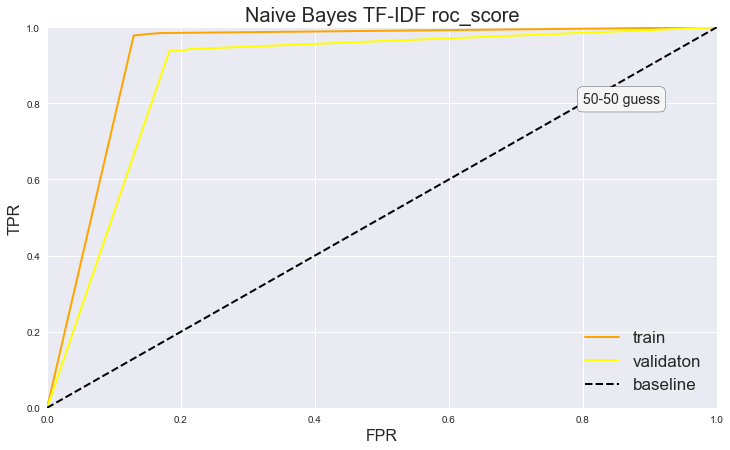

In [56]:
plot_roc_curve_1(naive_model, X_train, x_val, Y_train, y_val, 'Naive Bayes TF-IDF' )

# Naive Bayes with Count Vectorization

This section was just an experiment with the main intent to see if there was a major difference in terms of performance by using bag-of-words as vectorization method.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=9000)

# creating a bag-of-words matrix
X = cv.fit_transform(df['tweet_without_stopwords_and_2']).toarray()

# creating a parallel split of train/val to use only on the count vectorization matrix
from sklearn.model_selection import train_test_split
X_train_2, X_valid_2, y_train_2, y_val_2 = train_test_split(X, target, test_size = 0.2, random_state = 10)

from sklearn.naive_bayes import GaussianNB
classifier_bow = GaussianNB()
classifier_bow.fit(X_train_2, y_train_2)



GaussianNB(priors=None, var_smoothing=1e-09)

In [58]:
y_pred = classifier_bow.predict(X_valid_2)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val_2, y_pred)

In [59]:
cm

array([[2402, 1852],
       [ 195, 3950]])

In [60]:
Naive_Bayes_Tra_bow = calculate_performance_1(classifier_bow, X_train_2, y_train_2, 'Naive Bayes Training (b-o-w)')
Naive_Bayes_Tra_bow

,model,f1,accuracy,roc_score,precision
0,Naive Bayes Training (b-o-w),0.825409,0.792754,0.796797,0.70293


In [61]:
Naive_Bayes_Val_bow = calculate_performance_1(classifier_bow, X_valid_2, y_val_2, 'Naive Bayes Validation (b-o-w)')
Naive_Bayes_Val_bow



,model,f1,accuracy,roc_score,precision
0,Naive Bayes Validation (b-o-w),0.794209,0.756281,0.758807,0.6808


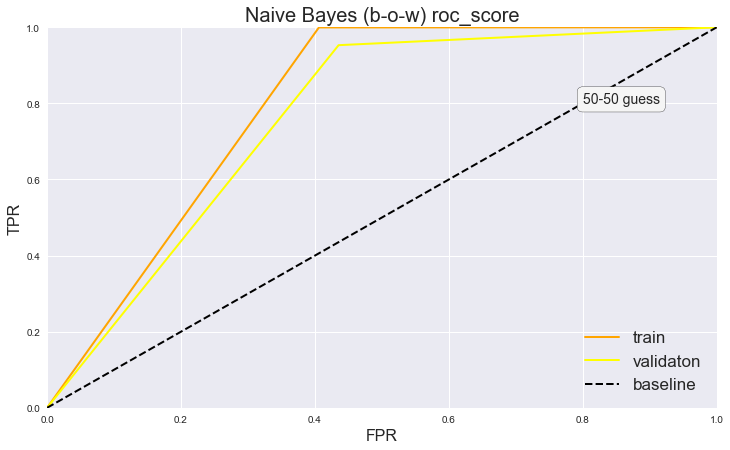

In [62]:
plot_roc_curve_1(classifier_bow, X_train_2, X_valid_2, y_train_2, y_val_2, "Naive Bayes (b-o-w)")

Performance significantly dropped by using a count vectorizer instead of tf-idf.

# Decision Tree

Instatiating a Decision Tree model

In [63]:
# initialising decision tree
DecisionTree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=86)
# fitting the decision tree 
tree_model = DecisionTree.fit(X_train, Y_train)

In [64]:
Decision_Tree_Tra = calculate_performance_1(tree_model, X_train, Y_train, 'Decision Tree Training')
Decision_Tree_Tra


,model,f1,accuracy,roc_score,precision
0,Decision Tree Training,0.879331,0.893726,0.892354,0.994267


In [65]:
Decision_Tree_Val = calculate_performance_1(tree_model, x_val, y_val, 'Decision Tree Validation')
Decision_Tree_Val 


,model,f1,accuracy,roc_score,precision
0,Decision Tree Validation,0.87698,0.891353,0.890566,0.993509


# Hyperparameter Tuning with Decision Tree

Decision Tree is the only model to get close to the our best model Logistic Regression. However, after some tuning it looks like performance doesn't get a lot better and it also takes a larger amount of time to process and run since our dataset is quite big.

In [66]:
cv_1 = StratifiedKFold(random_state=1050, shuffle=True, n_splits=3)

In [67]:
param_grid = {'max_depth': [5,6,7,8], 'min_samples_leaf': [5,10,15]}

In [68]:
opt_model_tree = GridSearchCV(DecisionTreeClassifier(random_state=23),
                             param_grid,
                             cv=cv_1,
                             return_train_score=True
                             )

In [69]:
opt_model_tree.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1050, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=23,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 6, 7, 8],
              

In [70]:
opt_model_tree.best_params_

{'max_depth': 8, 'min_samples_leaf': 10}

In [71]:
opt_model_tree.best_score_

0.934174294857483

In [72]:
pd.DataFrame(opt_model_tree.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,16.239471,0.715023,0.452423,0.114147,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.911932,0.913597,0.919504,0.915011,0.003249,12,0.916662,0.915885,0.912876,0.915141,0.001633
1,17.720866,1.754186,0.520060,0.137753,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.912044,0.913597,0.919504,0.915048,0.003214,10,0.916662,0.915885,0.912876,0.915141,0.001633
2,17.928033,0.467651,0.395028,0.035635,5,15,"{'max_depth': 5, 'min_samples_leaf': 15}",0.912044,0.913597,0.919504,0.915048,0.003214,10,0.916662,0.915885,0.912876,0.915141,0.001633
3,20.723197,2.673253,0.407164,0.039289,6,5,"{'max_depth': 6, 'min_samples_leaf': 5}",0.919076,0.920630,0.925198,0.921634,0.002598,9,0.923193,0.922472,0.920132,0.921932,0.001307
4,21.721751,0.957843,0.744517,0.262030,6,10,"{'max_depth': 6, 'min_samples_leaf': 10}",0.919187,0.920630,0.925198,0.921672,0.002562,7,0.923193,0.922472,0.920132,0.921932,0.001307
5,21.031882,2.279580,0.589312,0.267900,6,15,"{'max_depth': 6, 'min_samples_leaf': 15}",0.919187,0.920630,0.925198,0.921672,0.002562,7,0.923193,0.922472,0.920132,0.921932,0.001307
6,20.598567,1.017886,0.400412,0.041066,7,5,"{'max_depth': 7, 'min_samples_leaf': 5}",0.926554,0.927774,0.931004,0.928444,0.001877,6,0.929500,0.928946,0.927276,0.928574,0.000946
7,21.623282,0.328424,0.404098,0.009508,7,10,"{'max_depth': 7, 'min_samples_leaf': 10}",0.926666,0.927774,0.931004,0.928481,0.001840,4,0.929500,0.928946,0.927276,0.928574,0.000946
8,21.386091,1.189789,0.431797,0.039954,7,15,"{'max_depth': 7, 'min_samples_leaf': 15}",0.926666,0.927774,0.931004,0.928481,0.001840,4,0.929500,0.928946,0.927276,0.928574,0.000946
9,24.162761,1.848078,0.399973,0.028515,8,5,"{'max_depth': 8, 'min_samples_leaf': 5}",0.933363,0.933579,0.935469,0.934137,0.000946,3,0.935250,0.935198,0.933918,0.934788,0.000616


In [73]:
Decision_Tree_Tra_Opt = calculate_performance_1(opt_model_tree, X_train, Y_train, 'Decision Tree Training Optimised')
Decision_Tree_Tra_Opt


,model,f1,accuracy,roc_score,precision
0,Decision Tree Training Optimised,0.929131,0.934658,0.934791,0.994385


In [74]:
Decision_Tree_Validation_Opt = calculate_performance_1(opt_model_tree, x_val, y_val, 'Decision Tree Validation Optimised')
Decision_Tree_Validation_Opt

,model,f1,accuracy,roc_score,precision
0,Decision Tree Validation Optimised,0.92558,0.93124,0.9311,0.993087


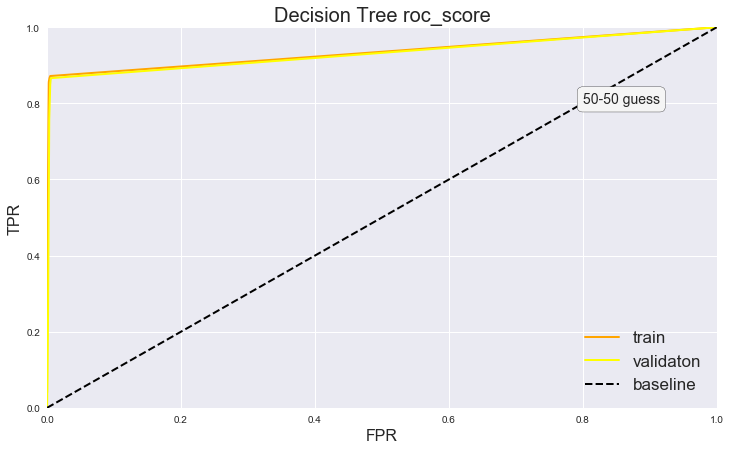

In [75]:
plot_roc_curve_1(opt_model_tree, X_train, x_val, Y_train, y_val,"Decision Tree")

# Evaluating all models performance

Attaching below a snapshot of all the different variations of our models

In [76]:
# concatenating all the results into a larger df
eval_df = pd.concat([Decision_Tree_Validation_Opt,
                    Decision_Tree_Tra_Opt,
                    Naive_Bayes_Val_bow,
                    Naive_Bayes_Tra_bow,
                    naive_model_val,
                    naive_model_train,
                    Logistic_Reg_Training_Opt, 
                    Logistic_Reg_Validation_Opt,
                    Logistic_Reg_Training,
                    Logistic_Reg_Validation])

In [77]:
# visualising all scores
eval_df

,model,f1,accuracy,roc_score,precision
0,Decision Tree Validation Optimised,0.925580,0.931240,0.931100,0.993087
0,Decision Tree Training Optimised,0.929131,0.934658,0.934791,0.994385
0,Naive Bayes Validation (b-o-w),0.794209,0.756281,0.758807,0.680800
0,Naive Bayes Training (b-o-w),0.825409,0.792754,0.796797,0.702930
0,Naive Bayes Validation (tf-idf),0.881919,0.876172,0.878681,0.832753
0,Naive Bayes Training (tf-idf),0.925761,0.922899,0.926856,0.878366
0,Logistic Regression Training Optimised,0.995415,0.995498,0.999164,0.995830
0,Logistic Regression Validation Optimised,0.982696,0.983033,0.996584,0.989001
0,Logistic Regression Training,0.983148,0.983590,0.997736,0.992057
0,Logistic Regression Validation,0.973551,0.974252,0.995979,0.986981


Logistic Regression Optimised performs better than all the other models from any metrics perspective with a final **98.2** f-1 score on the validation set.


All things considered I have seen that for the time being the best model seems to be a Logistic Regression with value C = 10.
Retraning the model on the whole training set instead of having the model trained on subsets of the stratified k-fold object.



In [78]:
# instatiating Logistic Regression with the best params
log_model_best = LogisticRegression(C = 10, random_state=1006)

In [79]:
# fitting the logistic regression
log_model_best.fit(X_train, Y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1006, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Another useful feature of Logistic Regression is the possibility of actually displaying the coefficients of the algorithm which should give an insight into what words are the most relevant in our classifier to differentiate positive from negative Tweets.

In [80]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(log_model_best.coef_))], axis = 1)

In [81]:
coefficients.columns=['word', 'coef']

In [82]:
coefficients.sort_values(by='coef', ascending=False, inplace=True)
coefficients = coefficients[:25]


In [83]:
coefficients.reset_index()

,index,word,coef
0,717,bitch,45.103282
1,3768,hoe,31.698257
2,6412,pussy,26.069221
3,2661,faggot,18.334207
4,6713,retard,16.372071
5,5683,nigger,16.304946
6,8170,trash,16.059374
7,1859,cunt,14.667797
8,2658,fag,14.573277
9,5664,niggah,14.171840


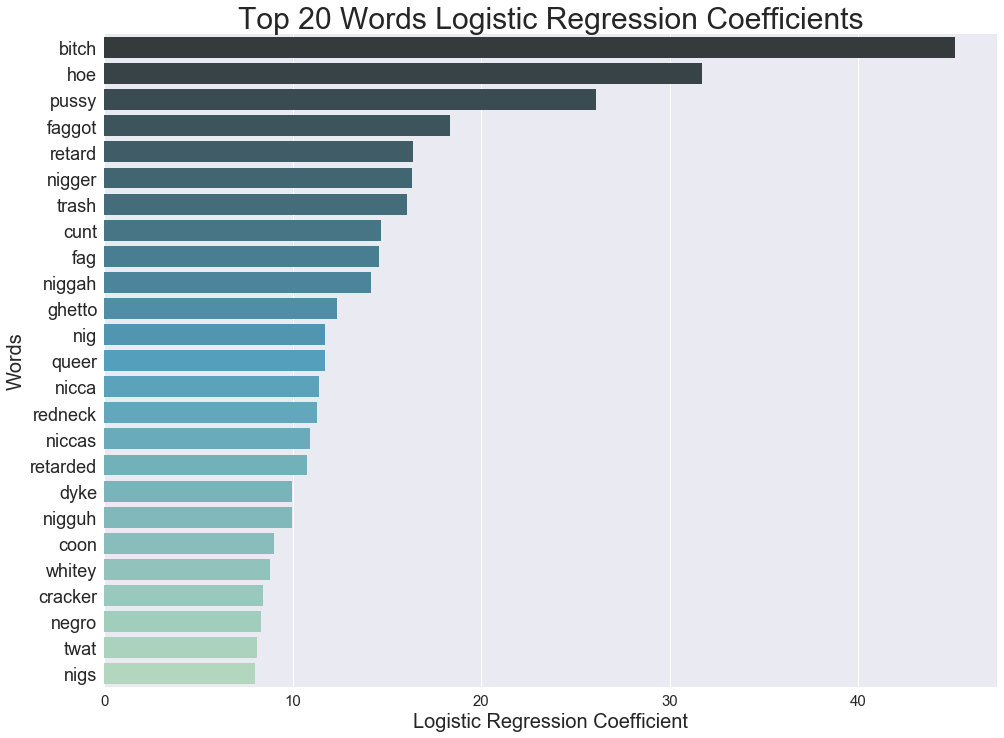

In [84]:
plt.figure(figsize=(16,12))
sns.barplot(coefficients['coef'],
            coefficients['word'], 
            orient = 'h',
            palette= 'GnBu_d'
            )

plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.xlabel('Logistic Regression Coefficient',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.title('Top 20 Words Logistic Regression Coefficients',fontsize=30)
plt.show()

# Testing Winning Model on Test Set

In [85]:
y_hat_log = log_model_best.predict(x_test)

In [86]:
cm = confusion_matrix(y_test, y_hat_log)

In [87]:
calculate_performance_1(log_model_best, x_test, y_test, 'Test Set Logistic Regression Winning Model')

,model,f1,accuracy,roc_score,precision
0,Test Set Logistic Regression Winning Model,0.987463,0.987856,0.997712,0.993323


Finally, we pickle the best performing model to be used on unseen Tweets in the following sections.

In [88]:
# instatiating the Logistic Regression
# log_model_best = LogisticRegression(C = 10, random_state=1006)

In [89]:
# fitting the logistic regression
# log_model_best.fit(X_train, Y_train)

In [90]:
log_model_best

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1006, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
# from joblib import dump, load

# pickle_log_model = open('best_log_model', 'wb')
# pickle.dump(log_model_best, pickle_log_model )

dump(log_model_best, 'filename.joblib')

In [92]:
dump(log_model_best, 'final_model')

['final_model']